# Online Signature Verification Challenge

#### Adnane Mehdaoui
#### Abdelghaffour Mouhsine
#### Yendoubouam Alexandre Lalle
#### Karim jtit
#### youssef aderdar
#### Rachid Baiou

In [1]:
# importation des bibliothéques nécessaires 
import pandas as pd
import math
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import euclidean
from itertools import combinations
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.calibration import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sn
import joblib

# chargement des fichiers de signature

In [2]:
def load_signature_data(file_path):
    # Définir les noms de colonnes
    column_names = ['x', 'y', 'timestamp', 'button', 'azimuth', 'altitude', 'pressure']
    
    # Charger le fichier CSV dans un DataFrame Pandas en utilisant les noms de colonnes
    df = pd.read_csv(file_path, sep=' ', index_col=False, names=column_names)

    # Supprimer la première ligne qui contient le nombre de lignes
    df = df.iloc[1:]

    # Réinitialiser les index du DataFrame
    df = df.reset_index(drop=True)
    
    return df 

#  calculer différentes caractéristiques de la signature à partir des coordonnées (x, y), de l'altitude et de l'azimuth de chaque point

In [3]:
def CalculeFeature(df):
    epsilon = 1e-8  # Petite valeur epsilon pour éviter la division par zéro
    # Calculer la différence de coordonnées à chaque instant
    delta_x = df['x'].diff()
    delta_y = df['y'].diff()

    # Calculer la norme de la vitesse à chaque instant
    delta_t = df['timestamp'].diff() + epsilon
    vitesse = np.sqrt(delta_x**2 + delta_y**2) / delta_t
    df['vitesse'] = vitesse
    
    # Calculer la norme de l'accélération à chaque instant
    acceleration = vitesse.diff() / delta_t
    df['acceleration'] = acceleration 

    # Calculer l'inclinaison du stylo
    pen_incl = np.arctan2(df['altitude'], df['azimuth'])
    df['pen_incl'] = pen_incl 
    
    # Calculer les dérivées secondes des coordonnées à chaque point
    
    dx = np.gradient(df['x'])
    dy = np.gradient(df['y'])

    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    denominator = np.power(dx*dx + dy*dy, 1.5) + epsilon  
    curvature = np.abs(d2x*dy - dx*d2y) / denominator
    
    df['curvature'] = curvature
    if df.isnull().any().any():  # Vérifier si une colonne a des valeurs nulles
        df = df.fillna(df.mean())
    return df  


# ajouter un champ label aux signatures de chaque utilisateur

In [4]:
def DonnerClasse(directory):
    # Initialiser une liste pour stocker les DataFrames de chaque utilisateur
    dfs = []
    # Parcourir tous les fichiers du répertoire
    for filename in os.listdir(directory):
        if filename.endswith('.TXT'):
            # Joindre le chemin du fichier avec le répertoire de travail actuel
            file_path = os.path.join(directory, filename)
            df = CalculeFeature(load_signature_data(file_path))
            # extraire l' id de l'utilisateur
            user_id, signature_id = filename.split('S')
            user_id = int(user_id[1:])
            signature_id = int(signature_id[:-4]) 

            df['classe'] = user_id
        
            # Ajouter le DataFrame à la liste
            dfs.append(df)
    
    # Concaténer tous les DataFrames en un seul DataFrame
    result = pd.concat(dfs, axis=0, ignore_index=True)

    return result  

# L'exploration des données 

In [5]:
# Définir le répertoire contenant les fichiers texte
directory = './data/Task1/'

data = DonnerClasse(directory)
data.head()

x       y   timestamp  button  azimuth  altitude  pressure    vitesse  \
0  3236  5028.0  17638839.0     0.0   1260.0     400.0     351.0  15.700367   
1  3428  4998.0  17638849.0     1.0   1260.0     400.0     382.0  19.432962   
2  3541  5056.0  17638859.0     1.0   1260.0     400.0     394.0  12.701575   
3  3665  5135.0  17638869.0     1.0   1310.0     400.0     397.0  14.702721   
4  3945  5229.0  17638879.0     1.0   1370.0     390.0     405.0  29.535741   

   acceleration  pen_incl  curvature  classe  
0      0.011582  0.307397   0.000990      10  
1      0.011582  0.307397   0.002234      10  
2     -0.673139  0.307397   0.001014      10  
3      0.200115  0.296352   0.000052      10  
4      1.483302  0.277335   0.000189      10

# visualisation de la distribution des données  

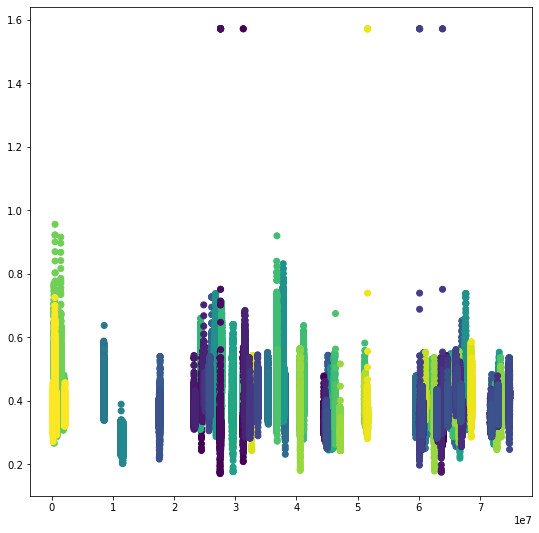

In [9]:
plt.figure(figsize=(9,9))
plt.scatter(data["timestamp"], data["pen_incl"], c=data["classe"])

# visualisation de la distribution des données en 3D

In [10]:
# visualisation 3D

%matplotlib    
from mpl_toolkits.mplot3d import Axes3D    

ax = plt.axes(projection='3d')
ax.scatter(data["x"], data["y"], data["timestamp"], c=data["classe"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Using matplotlib backend: <object object at 0x000001374916D810>


# visualisation de la distribution des données pour chaque paire de caractéristiques

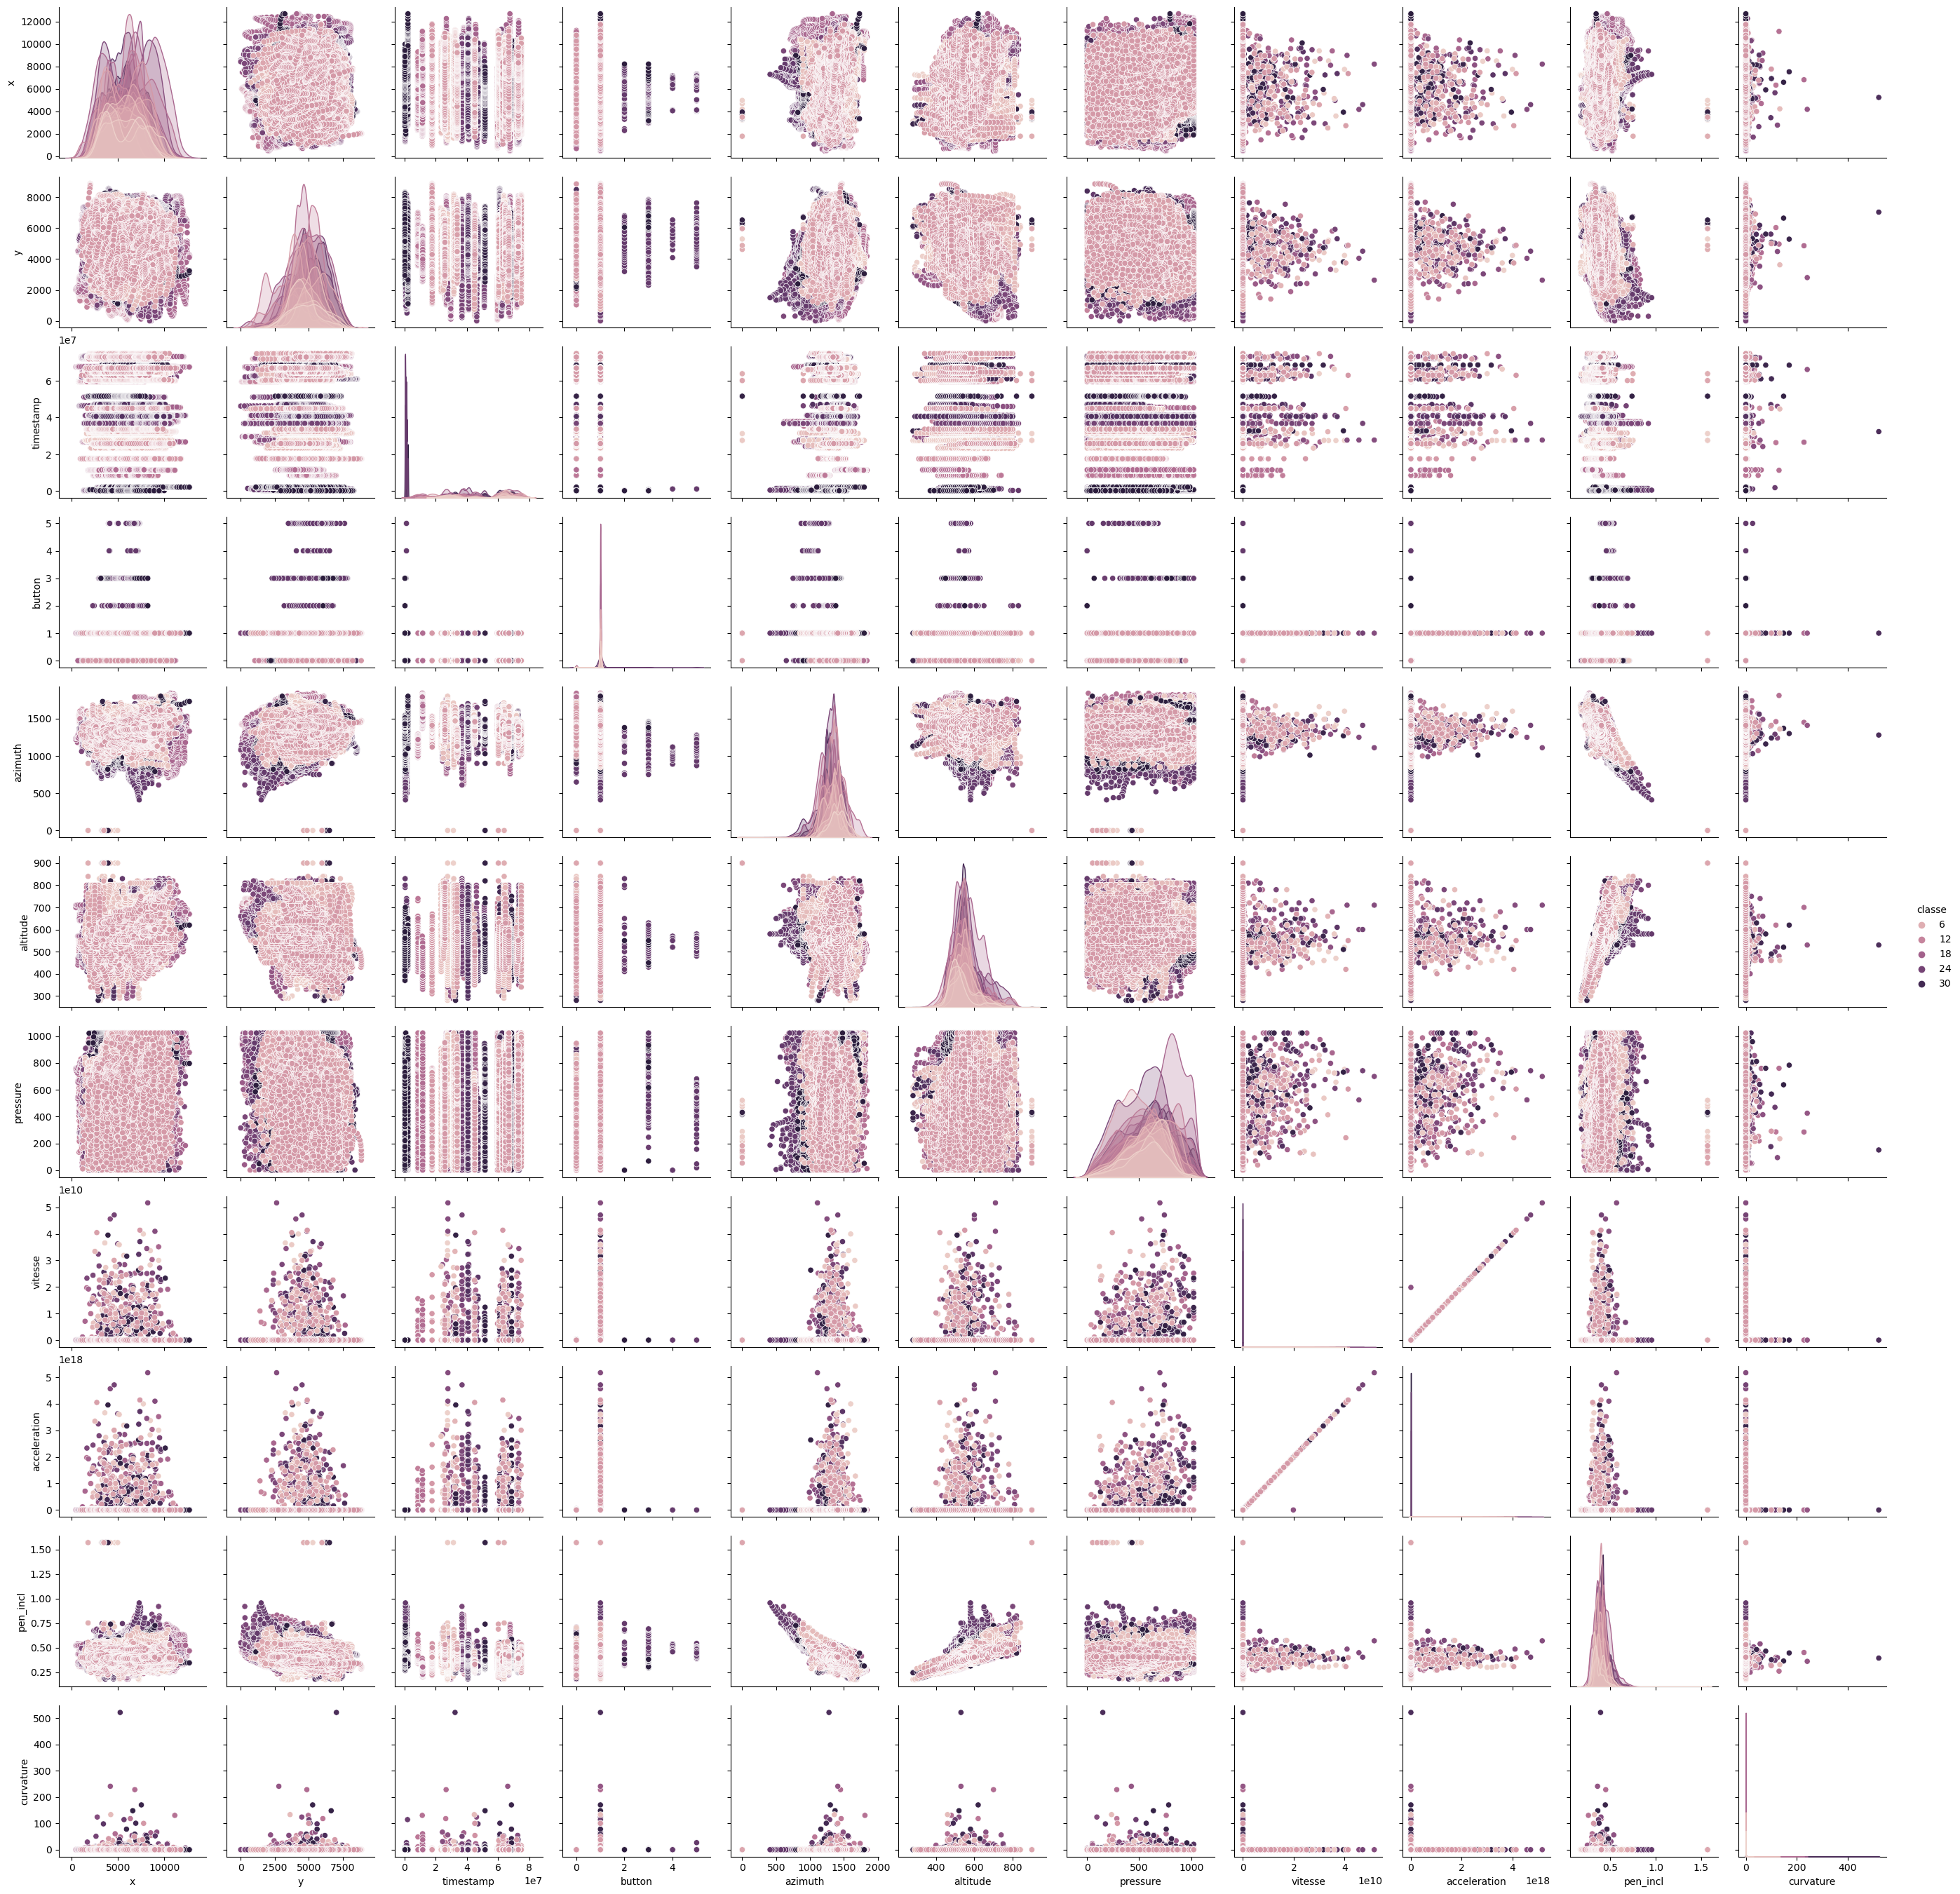

In [16]:
sn.pairplot(data, hue='classe')

# visualisation de la correlation entre chaque paire de variables

<AxesSubplot:>

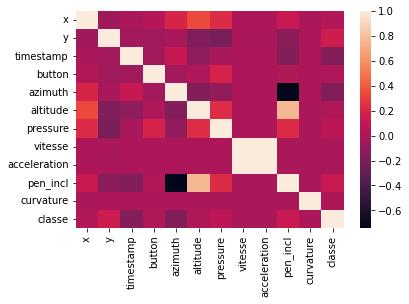

In [6]:
sn.heatmap(data.corr())

In [7]:
data.corr()

x         y  timestamp    button   azimuth  altitude  \
x             1.000000 -0.051062  -0.008948  0.030969  0.189916  0.333720   
y            -0.051062  1.000000  -0.035070 -0.041903 -0.018004 -0.179113   
timestamp    -0.008948 -0.035070   1.000000 -0.043829  0.111499 -0.114635   
button        0.030969 -0.041903  -0.043829  1.000000 -0.028973  0.009746   
azimuth       0.189916 -0.018004   0.111499 -0.028973  1.000000 -0.159886   
altitude      0.333720 -0.179113  -0.114635  0.009746 -0.159886  1.000000   
pressure      0.218019 -0.204595  -0.014257  0.182320 -0.104047  0.230342   
vitesse       0.001062 -0.004316   0.003494  0.003157  0.005446  0.003790   
acceleration  0.001007 -0.004351   0.003361  0.003165  0.005507  0.003918   
pen_incl      0.119879 -0.124486  -0.165561  0.025935 -0.742125  0.763034   
curvature    -0.000419  0.004737  -0.000145  0.004584  0.004245 -0.001731   
classe        0.021748  0.139025  -0.161620  0.008738 -0.176955  0.019799   

              pressure   vitesse  acceleration  pen_incl  curvature    classe  
x             0.218019  0.001062      0.001007  0.119879  -0.000419  0.021748  
y            -0.204595 -0.004316     -0.004351 -0.124486   0.004737  0.139025  
timestamp    -0.014257  0.003494      0.003361 -0.165561  -0.000145 -0.161620  
button        0.182320  0.003157      0.003165  0.025935   0.004584  0.008738  
azimuth      -0.104047  0.005446      0.005507 -0.742125   0.004245 -0.176955  
altitude      0.230342  0.003790      0.003918  0.763034  -0.001731  0.019799  
pressure      1.000000  0.004121      0.004105  0.223449  -0.010539  0.062436  
vitesse       0.004121  1.000000      0.998113 -0.001113  -0.000860 -0.001975  
acceleration  0.004105  0.998113      1.000000 -0.001055  -0.000860 -0.002052  
pen_incl      0.223449 -0.001113     -0.001055  1.000000  -0.003926  0.121385  
curvature    -0.010539 -0.000860     -0.000860 -0.003926   1.000000  0.006279  
classe        0.062436 -0.001975     -0.002052  0.121385   0.006279  1.000000

# Selectionner les caractéristiques pertinante sur lesquelles ont se base pour mesurer la simularité . (une correlation avec le target ("classe") elevée )

In [6]:
def selectFeatures(df):
    nouvelledf = df[['x', 'y', 'timestamp', 'azimuth', 'altitude', 'pressure', 'pen_incl']]
    return nouvelledf

# Séparer les données en ensembles d'entraînement et de test

In [7]:
X = selectFeatures(data)
y = data['classe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Remplacer les valeurs infinies ou trop grandes par NaN
X_train[~np.isfinite(X_train)] = 0
X_test[~np.isfinite(X_test)] = 0

# Imputer les valeurs manquantes par la moyenne de chaque colonne
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


# Definition et entrainement de Model avec la methode KNN 

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
def KNN(X_train, X_test, y_train, y_test):    
    # Trouver les meilleurs hyperparamètres pour le modèle
    param_grid = {'n_neighbors': np.arange(1,5),'metric': ['euclidean', 'manhattan']}
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
    
    # Entrainement de model
    grid.fit(X_train, y_train)

    # Prédire les classes pour les données de test
    y_pred = grid.predict(X_test)

    print(f"les meilleurs paramètres sont : {grid.best_params_}")
    print(f"La performance du modèle avec ces paramètres : {grid.best_score_}")

    # Calculer l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('knn Accuracy:', accuracy)

    return grid 

In [11]:
def training(X_train, X_test, y_train, y_test):
    knn=KNN(X_train, X_test, y_train, y_test) 
    return knn

In [12]:
knn = training(X_train, X_test, y_train, y_test)

les meilleurs paramètres sont : {'metric': 'manhattan', 'n_neighbors': 1}
La performance du modèle avec ces paramètres : 0.9999542480015645
knn Accuracy: 0.9998838883470345


# Enregestrement de Model en disque dur

In [13]:
joblib.dump(knn,"Model_Signature_Verification.joblib")

['Model_Signature_Verification.joblib']

# Chargement de Model

In [14]:
model = joblib.load("./Model_Signature_Verification.joblib")

In [15]:
def compare_signatures(signature_path1, signature_path2):
    
    model = joblib.load("./Model_Signature_Verification.joblib")
    signature1 = selectFeatures(CalculeFeature(load_signature_data(signature_path1)))
    signature2 = selectFeatures(CalculeFeature(load_signature_data(signature_path2)))
   
    minN = min(len(signature1), len(signature2))
    
    y1=model.predict(signature1.iloc[:minN,:])
    y2=model.predict(signature2.iloc[:minN,:]) 
    
    accuracy = accuracy_score(y1, y2)   
    
    if accuracy>0.50 : 
        similarity = True
    else :
        similarity = False
    return accuracy , similarity 


# tester le modéle 

In [17]:

acc,sm = compare_signatures("./data/Test/U10S11.TXT", "./data/Test/U10S16.TXT")
print("accuracy : ",acc)
print("similarity : ",sm)

accuracy :  1.0
similarity :  True


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


#  Ecrire les résultats dans un fichier CSV chaque fois qu'on fait des combinaisons entre deux signatures aléatoirement choisies.

In [18]:
test_folder_path = './data/Test/'
train_folder_path = './data/Task1/'
train_files = os.listdir(train_folder_path)

files_paths = [os.path.join(test_folder_path, filename) for filename in os.listdir(test_folder_path)]
    
random_files_paths = random.sample(files_paths, 30)

In [19]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

file_info = [{'file_name': os.path.basename(file_path), 'file_path': file_path} for file_path in random_files_paths]

file_combinations = combinations(file_info, 2)
results = []

results_df = pd.DataFrame(columns=['File 1', 'File 2', 'Similarity'])

for file_pair in file_combinations:
    file1, file2 = file_pair
    acc, sm = compare_signatures(file1['file_path'], file2['file_path'])
    if sm :
        label=0
    else:
        label=1
    results.append({'File 1': file1['file_name'], 'File 2': file2['file_name'], 'Similarity': label})

results_df = pd.concat([results_df, pd.DataFrame(results)], ignore_index=True)
results_df.to_csv('comparison_results.csv', index=False)


# Evaluation

In [22]:
# Calculer la précision, le rappel et le F1-score
y_pred = model.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9998511578442126
Recall: 0.9998662387989318
F1-score: 0.9998586766676647



Confusion Matrix:
 [[1460    0    0 ...    0    0    0]
 [   0 1655    0 ...    0    0    0]
 [   0    0 1601 ...    0    0    0]
 ...
 [   0    0    0 ... 2251    0    0]
 [   0    0    0 ...    0 2324    0]
 [   0    0    0 ...    0    0 2174]]


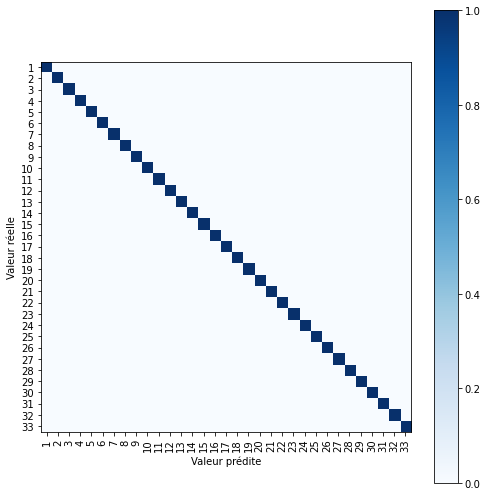

In [23]:
############################### Matrice de confusion ###########################################################
    
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Normaliser la matrice de confusion pour montrer la proportion de prédictions correctes pour chaque classe
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Afficher la matrice de confusion
#np.set_printoptions(threshold=np.inf)
print("\nConfusion Matrix:\n", cm)
   
   
plt.figure(figsize=(7, 7))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_pred), rotation=90)
plt.yticks(tick_marks, np.unique(y_test))
plt.tight_layout()
plt.xlabel('Valeur prédite')
plt.ylabel('Valeur réelle')
plt.show()

# courbes de précision-rappel (precision-recall) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


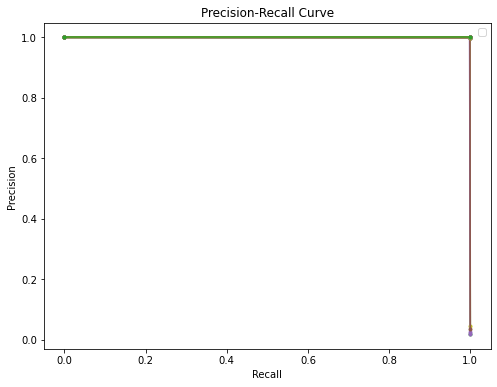

In [24]:
# Convertir les étiquettes multiclasse en étiquettes binaires
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculer les probabilités pour chaque classe en utilisant predict_proba
y_scores = knn.predict_proba(X_test)

# Calculer la précision et le rappel pour chaque classe
precision_curve = dict()
recall_curve = dict()
for i in range(len(np.unique(y_test))):
    precision_curve[i], recall_curve[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])

# Tracer les courbes de précision-rappel pour chaque classe
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    # plt.plot(recall_curve[i], precision_curve[i], marker='.', label=f'Class {i}')
    plt.plot(recall_curve[i], precision_curve[i], marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# courbes ROC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


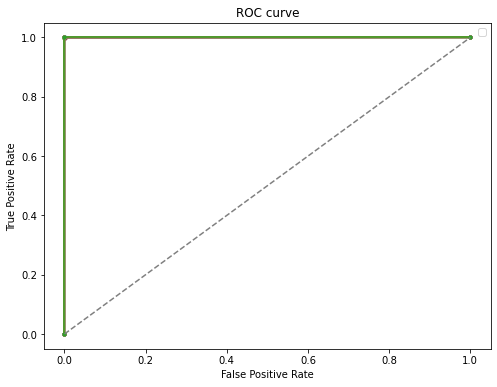

In [25]:
# Calculer le taux de faux positifs, le taux de vrais positifs et l'aire sous la courbe ROC (AUC) pour chaque classe
fpr = dict()
tpr = dict()
# roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    # roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    # plt.plot(fpr[i], tpr[i], marker='.', label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot(fpr[i], tpr[i], marker='.')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()